# Train and evaluate Explainers

With all these prerequisites out of the way you can now run the experiments themselves. The experiments are run for each
explanation method (T-GNNExplainer, GreDyCF, CoDy), for each dataset, for each correct/incorrect setting 
(correct predictions only/incorrect predictions only), and for each selection policy (random, temporal, spatio-temporal, 
local-gradient) separately. For convenience, all selection strategies can be automatically evaluated in parallel from a 
single script. An additional feature of the evaluation is that it can be interrupted by Keyboard Interruption or by the
maximum processing time. When the evaluation is interrupted before it is finished, the intermediary results are saved. 
The evaluation automatically resumes from intermediary results.

In [1]:
# Find and add `notebooks/src` to sys.path, no matter where the notebook lives.
from pathlib import Path
import json
import sys, importlib
import os, re
import torch
from collections import defaultdict
from IPython.display import display
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
def _add_notebooks_src_to_path():
    here = Path.cwd().resolve()
    for p in [here, *here.parents]:
        candidate = p / "notebooks" / "src"
        if candidate.is_dir():
            if str(candidate) not in sys.path:
                sys.path.insert(0, str(candidate))
            return candidate
    raise FileNotFoundError("Could not find 'notebooks/src' from current working directory.")

print("Using helpers from:", _add_notebooks_src_to_path())

from constants import (
    REPO_ROOT, PKG_DIR, RESOURCES_DIR, PROCESSED_DATA_DIR, MODELS_ROOT, TGN_SUBMODULE_ROOT, ensure_repo_importable, get_last_checkpoint,
    load_notebook_config,
)
ensure_repo_importable()
from device import pick_device
NOTEBOOK_CFG = load_notebook_config()
SEED = int(NOTEBOOK_CFG.get("seed", 42))
DEVICE = pick_device(NOTEBOOK_CFG.get("device", "auto"))
print(f"Notebook config: seed={SEED}, device={DEVICE}")

if "DEVICE" not in globals():
    import torch
    try:
        from device import pick_device
        DEVICE = pick_device(NOTEBOOK_CFG.get("device", "auto") if "NOTEBOOK_CFG" in globals() else "auto")
    except Exception:
        DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print("Using device:", DEVICE)
for p in (str(TGN_SUBMODULE_ROOT), str(REPO_ROOT), str(PKG_DIR)):
    if p not in sys.path:
        sys.path.insert(0, p)

# 2) If your notebook already imported `utils`, remove it to avoid collision
if "utils" in sys.modules:
    del sys.modules["utils"]

importlib.invalidate_caches()

# 4) (Optional) sanity check that TGN's local packages resolve
import importlib.util as iu
print("utils.utils   ->", iu.find_spec("utils.utils"))
print("modules.memory->", iu.find_spec("modules.memory"))


print("REPO_ROOT        :", REPO_ROOT)
print("PKG_DIR          :", PKG_DIR)
print("RESOURCES_DIR    :", RESOURCES_DIR)
print("PROCESSED_DATA_DIR:", PROCESSED_DATA_DIR)
print("MODELS_ROOT      :", MODELS_ROOT)


Using helpers from: /Users/juliawenkmann/Documents/CodingProjects/master_thesis/time_to_explain/notebooks/src
Notebook config: seed=42, device=mps
utils.utils   -> None
modules.memory-> ModuleSpec(name='modules.memory', loader=<_frozen_importlib_external.SourceFileLoader object at 0x1124a7790>, origin='/Users/juliawenkmann/Documents/CodingProjects/master_thesis/time_to_explain/submodules/models/tgn/modules/memory.py')
REPO_ROOT        : /Users/juliawenkmann/Documents/CodingProjects/master_thesis/time_to_explain
PKG_DIR          : /Users/juliawenkmann/Documents/CodingProjects/master_thesis/time_to_explain/time_to_explain
RESOURCES_DIR    : /Users/juliawenkmann/Documents/CodingProjects/master_thesis/time_to_explain/resources
PROCESSED_DATA_DIR: /Users/juliawenkmann/Documents/CodingProjects/master_thesis/time_to_explain/resources/datasets/processed
MODELS_ROOT      : /Users/juliawenkmann/Documents/CodingProjects/master_thesis/time_to_explain/resources/models


## Imports

In [2]:
from time_to_explain.utils.graph import NeighborFinder
# Core imports
from time_to_explain.data.legacy.tg_dataset import load_explain_idx
from time_to_explain.data.workflows import load_processed_dataset_safe
from submodules.models.tgat.module import TGAN
from submodules.models.tgn.model.tgn import TGN
from submodules.explainer.tgnnexplainer.tgnnexplainer.xgraph.models.ext.tgn.utils.data_processing import compute_time_statistics

from time_to_explain.core.runner import EvaluationRunner, EvalConfig
import json
METRICS_CFG = json.loads((REPO_ROOT / "configs" / "metrics" / "default.json").read_text())
from time_to_explain.visualization import plot_selected_metrics

from time_to_explain.adapters import *
from time_to_explain.adapters.greedy_adapter import GreedyAdapter, GreedyAdapterConfig
from time_to_explain.extractors.base_extractor import BaseExtractor
from time_to_explain.extractors.khop_extractor import KHopCandidatesExtractor
from time_to_explain.extractors.random_extractor import RandomExtractor
from time_to_explain.visualization import (
    filter_explainers,
    plot_explainer_metric_summary,
    plot_explainer_runtime,
    prepare_metrics_plotting,
    plot_prediction_match_rate,
)

from time_to_explain.explainer.shap import ShapAdapterConfig, ShapExplainer
from time_to_explain.explainer.gradient import GradientAdapterConfig, GradientExplainer
from time_to_explain.explainer.tempme import TempMEAdapter, TempMEAdapterConfig
from time_to_explain.explainer.tempme_tgn_impl import TempMETGNImplAdapter, TempMETGNImplAdapterConfig
from time_to_explain.explainer.cody_tgn_impl import CoDyTGNImplAdapter, CoDyTGNImplAdapterConfig


Using REPO_ROOT / ROOT_DIR: /Users/juliawenkmann/Documents/CodingProjects/master_thesis/time_to_explain
Using REPO_ROOT / ROOT_DIR: /Users/juliawenkmann/Documents/CodingProjects/master_thesis/time_to_explain


## Config

In [3]:
MODEL_TYPE = "tgn"
DATASET_NAME = "wikipedia"
TIME_LIMIT = 240

N = 1
USE_CACHED_RESULTS = False

## Load Dataset and Model

In [4]:
def _find_checkpoint(models_root: Path, dataset_name: str, model_name: str) -> Path:
    model_name = model_name.lower()
    dataset_name = str(dataset_name)
    candidates = [
        models_root / dataset_name / model_name / f"{model_name}_{dataset_name}_best.pth",
        models_root / dataset_name / "checkpoints" / f"{model_name}_{dataset_name}_best.pth",
        models_root / "checkpoints" / f"{model_name}_{dataset_name}_best.pth",
    ]
    for cand in candidates:
        if cand.exists():
            return cand
    search_roots = [
        models_root / dataset_name / model_name,
        models_root / dataset_name,
        models_root / "checkpoints",
        models_root / "runs",
    ]
    for root in search_roots:
        if not root.exists():
            continue
        matches = sorted(root.rglob(f"{model_name}*{dataset_name}*.pth"))
        if not matches:
            matches = sorted(root.rglob("*.pth"))
        for match in matches:
            if "best" in match.name:
                return match
        if matches:
            return matches[0]
    raise FileNotFoundError(
        f"Checkpoint not found under {models_root} for {model_name}_{dataset_name}."
    )

ckpt_path = _find_checkpoint(MODELS_ROOT, DATASET_NAME, MODEL_TYPE)
print("Using checkpoint:", ckpt_path)
explain_idx_csv = str(RESOURCES_DIR / "explainer" / "explain_index" / f"{DATASET_NAME}.csv")
print("Explain index CSV:", explain_idx_csv)

Using checkpoint: /Users/juliawenkmann/Documents/CodingProjects/master_thesis/time_to_explain/resources/models/wikipedia/tgn/tgn_wikipedia_best.pth
Explain index CSV: /Users/juliawenkmann/Documents/CodingProjects/master_thesis/time_to_explain/resources/explainer/explain_index/wikipedia.csv


In [5]:
# Load data
try:
    bundle = load_processed_dataset_safe(DATASET_NAME, verbose=True)
except FileNotFoundError as exc:
    raise FileNotFoundError(
        f"Processed dataset {DATASET_NAME!r} not found. "
        "Run notebooks/00_prepare_datasets.ipynb for this dataset."
    ) from exc
events = bundle["interactions"]
edge_feats = bundle.get("edge_features")
node_feats = bundle.get("node_features")
metadata = bundle.get("metadata") or {}
config_meta = metadata.get("config") if isinstance(metadata.get("config"), dict) else {}
def _infer_bipartite_from_events(df: pd.DataFrame) -> bool:
    if len(df) == 0:
        return False
    u_min, u_max = int(df["u"].min()), int(df["u"].max())
    i_min, i_max = int(df["i"].min()), int(df["i"].max())
    return i_min > u_max or u_min > i_max

is_bipartite = metadata.get("bipartite", config_meta.get("bipartite"))
if is_bipartite is None:
    is_bipartite = _infer_bipartite_from_events(events)
else:
    is_bipartite = bool(is_bipartite)
if DATASET_NAME in {"stick_figure", "sticky_hips"}:
    is_bipartite = False

def _build_neighbor_finder(df: pd.DataFrame) -> NeighborFinder:
    u = df["u"].to_numpy(dtype=int)
    v = df["i"].to_numpy(dtype=int)
    ts = df["ts"].to_numpy(dtype=float)
    if "e_idx" in df.columns:
        e_idx = df["e_idx"].to_numpy(dtype=int)
    elif "idx" in df.columns:
        e_idx = df["idx"].to_numpy(dtype=int)
    else:
        e_idx = np.arange(1, len(df) + 1, dtype=int)
    max_node = int(max(u.max(), v.max())) if len(df) else 0
    adj_list = [[] for _ in range(max_node + 1)]
    for src, dst, t, e in zip(u, v, ts, e_idx):
        adj_list[int(src)].append((int(dst), int(e), float(t)))
        adj_list[int(dst)].append((int(src), int(e), float(t)))
    return NeighborFinder(adj_list, uniform=False)

configs_dir = REPO_ROOT / "configs" / "models"
config_candidates = [
    configs_dir / f"compare_{MODEL_TYPE.lower()}_{DATASET_NAME}.json",
    configs_dir / f"compare_{MODEL_TYPE.lower()}.json",
    configs_dir / f"infer_{MODEL_TYPE.lower()}_{DATASET_NAME}.json",
    configs_dir / f"infer_{MODEL_TYPE.lower()}.json",
]
model_config_path = next((p for p in config_candidates if p.exists()), None)
if model_config_path is None:
    raise FileNotFoundError(
        "Model config not found. Expected one of: "
        + ", ".join(str(p) for p in config_candidates)
    )
model_config = json.loads(model_config_path.read_text())
config_model = str(model_config.get("model", "")).lower()
if config_model and config_model != MODEL_TYPE.lower():
    raise ValueError(
        f"Config model {config_model!r} does not match MODEL_TYPE={MODEL_TYPE!r}"
    )
model_args = dict(model_config.get("args") or {})
print(f"Using model config: {model_config_path}")

# Build the backbone model
if MODEL_TYPE == "tgat":
    if not is_bipartite:
        raise ValueError("TGAT expects bipartite datasets; set MODEL_TYPE='tgn' for stick_figure.")
    ngh_finder = _build_neighbor_finder(events)
    backbone = TGAN(
        ngh_finder,
        node_feats,
        edge_feats,
        device=DEVICE,
        **model_args,
    )
elif MODEL_TYPE == "tgn":
    m_src, s_src, m_dst, s_dst = compute_time_statistics(events.u.values, events.i.values, events.ts.values)
    ngh_finder = _build_neighbor_finder(events)   # your utils often reuse the same NF
    backbone = TGN(
        ngh_finder,
        node_feats,
        edge_feats,
        device=DEVICE,
        mean_time_shift_src=m_src,
        std_time_shift_src=s_src,
        mean_time_shift_dst=m_dst,
        std_time_shift_dst=s_dst,
        **model_args,
    )
else:
    raise NotImplementedError(MODEL_TYPE)

# Load backbone weights
state_dict = torch.load(ckpt_path, map_location="cpu")
_ = backbone.load_state_dict(state_dict, strict=False)
_ = backbone.to(DEVICE).eval()
print("Backbone ready on", DEVICE)
# Wrap backbone with ModelProtocol adapter (adds predict_proba & masking)
model = TemporalGNNModelAdapter(backbone, events, device=DEVICE)


Loaded flat processed files for 'wikipedia'.
Using model config: /Users/juliawenkmann/Documents/CodingProjects/master_thesis/time_to_explain/configs/models/infer_tgn.json
Backbone ready on mps


/var/folders/k7/xf0yhfbs02ggfm7n1l5g_cnm0000gn/T/ipykernel_38730/3652151995.py:98: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(ckpt_path, map_locat

## Build Extractor and Explainer

### Build Extractor

In [6]:
# Extractors: main for mask-based explainers (reused for TempME so fidelity masks align)
extractor_main = BaseExtractor(
    model=model,
    events=events,
    threshold_num=5000,
    keep_order="last-N-then-sort",
)

khop_ext_75 = KHopCandidatesExtractor(
    model=model,
    events=events,
    candidates_size=75,
)

khop_ext_150 = KHopCandidatesExtractor(
    model=model,
    events=events,
    candidates_size=150,
)

random_ext_sample_75 = RandomExtractor(
    model=model,
    events=events,
    candidates_size=75,
    pool="history",
    random_mode="sample",
    seed=SEED,
    per_anchor_seed=True,
    keep_sorted_by_time=True,
)

EXTRACTOR_VARIANTS = {
    "base": extractor_main,
    "khop_75": khop_ext_75,
    "khop_150": khop_ext_150,
    "random_sample_75": random_ext_sample_75,
}


<hr style="height:1px;border:none;background:#ccc;">


### Build Explainer

In [7]:
from time_to_explain.explainer.loader import make_explainer_builder

build_explainer = make_explainer_builder(
    dataset_name=DATASET_NAME,
    model_type=MODEL_TYPE,
    device=DEVICE,
    seed=SEED,
    callable_scope=globals(),
)


#### 1) TGNNExplainer/TGNNExplainer

In [8]:
tgnnexplainer_explainer = build_explainer("tgnnexplainer")

Built explainer 'tgnnexplainer' from /Users/juliawenkmann/Documents/CodingProjects/master_thesis/time_to_explain/configs/explainer/tgnnexplainer.json


#### 2) Tempme

In [9]:
# TempME adapter (motif-based explainer)
from submodules.explainer.tgnnexplainer.tgnnexplainer.xgraph.method.tg_score import _set_tgat_data

def tempme_score_fn(model, dataset, target_event_idx, active_event_ids=None):
    events_df = dataset.get("events") if isinstance(dataset, dict) else dataset
    src_idx_l, target_idx_l, cut_time_l = _set_tgat_data(events_df, target_event_idx)
    preserve = list(active_event_ids) if active_event_ids else None
    out = model.get_prob(src_idx_l, target_idx_l, cut_time_l, logit=True, edge_idx_preserve_list=preserve)
    return float(out.detach().cpu().item()) if hasattr(out, "detach") else float(out)

tempme_explainer = build_explainer("tempme")
tempme_tgn_impl_explainer = build_explainer("tempme_tgn_impl")
tempme_neural_explainer = build_explainer("tempme_neural")

Built explainer 'tempme' from /Users/juliawenkmann/Documents/CodingProjects/master_thesis/time_to_explain/configs/explainer/tempme.json
Built explainer 'tempme_tgn_impl' from /Users/juliawenkmann/Documents/CodingProjects/master_thesis/time_to_explain/configs/explainer/tempme_tgn_impl.json
Built explainer 'tempme_neural' from /Users/juliawenkmann/Documents/CodingProjects/master_thesis/time_to_explain/configs/explainer/tempme_neural.json


#### 3) GreeDy and CoDy

In [10]:
cody_explainer = build_explainer("cody")
cody_tgn_impl_explainer = build_explainer("cody_tgn_impl")

greedy_explainer = build_explainer("greedy")

Built explainer 'cody' from /Users/juliawenkmann/Documents/CodingProjects/master_thesis/time_to_explain/configs/explainer/cody.json
Built explainer 'cody_tgn_impl' from /Users/juliawenkmann/Documents/CodingProjects/master_thesis/time_to_explain/configs/explainer/cody_tgn_impl.json
Built explainer 'greedy' from /Users/juliawenkmann/Documents/CodingProjects/master_thesis/time_to_explain/configs/explainer/greedy.json


#### 4) PGExplainer

In [11]:
pg_explainer = build_explainer("pg")
temgx_explainer = build_explainer("temgx")

Built explainer 'pg' from /Users/juliawenkmann/Documents/CodingProjects/master_thesis/time_to_explain/configs/explainer/pg.json
Built explainer 'temgx' from /Users/juliawenkmann/Documents/CodingProjects/master_thesis/time_to_explain/configs/explainer/temgx.json


#### 5) GNNExplainer

In [12]:
gnn_explainer = build_explainer("gnn")

Built explainer 'gnn' from /Users/juliawenkmann/Documents/CodingProjects/master_thesis/time_to_explain/configs/explainer/gnn.json


#### 6) LIME

In [13]:
perturb_one_explainer = build_explainer("perturb_one")

Built explainer 'perturb_one' from /Users/juliawenkmann/Documents/CodingProjects/master_thesis/time_to_explain/configs/explainer/perturb_one.json


#### 7) SHAP

In [14]:
from submodules.explainer.tgnnexplainer.tgnnexplainer.xgraph.method.tg_score import _set_tgat_data

def shap_score_fn(model, dataset, target_event_idx, active_event_ids):
    events_df = dataset.get("events") if isinstance(dataset, dict) else dataset
    src_idx_l, target_idx_l, cut_time_l = _set_tgat_data(events_df, target_event_idx)
    preserve = list(active_event_ids) if active_event_ids else None
    out = model.get_prob(src_idx_l, target_idx_l, cut_time_l, logit=True, edge_idx_preserve_list=preserve)
    return float(out.detach().cpu().item()) if hasattr(out, "detach") else float(out)

shap_explainer = build_explainer("shap")

Built explainer 'shap' from /Users/juliawenkmann/Documents/CodingProjects/master_thesis/time_to_explain/configs/explainer/shap.json


#### 8) Gradient

In [15]:
# Gradient-based explainer (integrated gradients over event mask)
import torch
from time_to_explain.core.types import Subgraph

def grad_forward_fn(model, dataset, target_event_idx, candidate_eidx, mask):
    subgraph = Subgraph(node_ids=[], edge_index=[], payload={"candidate_eidx": list(candidate_eidx), "event_idx": int(target_event_idx)})
    score = model.predict_proba_with_mask(subgraph, {"event_idx": int(target_event_idx)}, edge_mask=mask)
    if isinstance(score, torch.Tensor):
        return score.squeeze()
    return torch.as_tensor(score, device=mask.device, dtype=mask.dtype).squeeze()

grad_explainer = build_explainer("grad")

Built explainer 'grad' from /Users/juliawenkmann/Documents/CodingProjects/master_thesis/time_to_explain/configs/explainer/grad.json


#### 9) Attention

In [16]:
attn_explainer = build_explainer("attn")

Built explainer 'attn' from /Users/juliawenkmann/Documents/CodingProjects/master_thesis/time_to_explain/configs/explainer/attn.json


#### 10) Random Baselines

In [17]:
EXPLAINER_BASES = [
    "random",
    "degree",
    "cody",
    "cody_tgn_impl",
    "greedy",
    "temgx",
    "attn",
    "grad",
    "shap",
    "tgnnexplainer",
]


EXTRACTOR_VARIANTS_BY_EXPLAINER = None  # e.g. {"tgnnexplainer": ["base", "khop_75"]}

RUN_BASE_EXPLAINERS = None  # e.g. ["random", "cody"]
RUN_EXTRACTOR_VARIANTS = None  # e.g. ["base", "khop_75"]
RUN_EXPLAINERS = None  # exact alias list, e.g. ["random__base"]

EXPLAINER_MAP = {}
EXTRACTOR_MAP = {}
EXPLAINER_NAMES = []

for base in EXPLAINER_BASES:
    variant_names = list(EXTRACTOR_VARIANTS.keys())
    if EXTRACTOR_VARIANTS_BY_EXPLAINER and base in EXTRACTOR_VARIANTS_BY_EXPLAINER:
        variant_names = EXTRACTOR_VARIANTS_BY_EXPLAINER[base]
    for variant in variant_names:
        alias = f"{base}__{variant}"
        explainer = build_explainer(base, overrides={"alias": alias})
        EXPLAINER_MAP[alias] = explainer
        EXTRACTOR_MAP[alias] = EXTRACTOR_VARIANTS[variant]
        EXPLAINER_NAMES.append(alias)

if RUN_BASE_EXPLAINERS:
    EXPLAINER_NAMES = [name for name in EXPLAINER_NAMES if name.split("__", 1)[0] in RUN_BASE_EXPLAINERS]
if RUN_EXTRACTOR_VARIANTS:
    EXPLAINER_NAMES = [name for name in EXPLAINER_NAMES if name.split("__", 1)[1] in RUN_EXTRACTOR_VARIANTS]
if RUN_EXPLAINERS:
    EXPLAINER_NAMES = [name for name in EXPLAINER_NAMES if name in RUN_EXPLAINERS]

EXPLAINERS = [EXPLAINER_MAP[name] for name in EXPLAINER_NAMES]
EXTRACTOR_MAP = {name: EXTRACTOR_MAP[name] for name in EXPLAINER_NAMES}
print("Explainers configured:", [e.alias for e in EXPLAINERS])


Built explainer 'random__base' from /Users/juliawenkmann/Documents/CodingProjects/master_thesis/time_to_explain/configs/explainer/random.json
Built explainer 'random__khop_75' from /Users/juliawenkmann/Documents/CodingProjects/master_thesis/time_to_explain/configs/explainer/random.json
Built explainer 'random__khop_150' from /Users/juliawenkmann/Documents/CodingProjects/master_thesis/time_to_explain/configs/explainer/random.json
Built explainer 'random__random_sample_75' from /Users/juliawenkmann/Documents/CodingProjects/master_thesis/time_to_explain/configs/explainer/random.json
Built explainer 'degree__base' from /Users/juliawenkmann/Documents/CodingProjects/master_thesis/time_to_explain/configs/explainer/degree.json
Built explainer 'degree__khop_75' from /Users/juliawenkmann/Documents/CodingProjects/master_thesis/time_to_explain/configs/explainer/degree.json
Built explainer 'degree__khop_150' from /Users/juliawenkmann/Documents/CodingProjects/master_thesis/time_to_explain/configs/ex

<hr style="height:1px;border:none;background:#ccc;">


## Select Explainers

In [18]:
# Explainer variants configured above.


## Define Metrics

In [19]:
# Load 1-based event indices you want to explain (same file the Hydra pipeline uses)
target_event_idxs = load_explain_idx(explain_idx_csv, start=0)

# Build anchors (we keep "target_kind" for compatibility; the crucial piece is event_idx)
anchors = [{"target_kind": "edge", "event_idx": int(e)} for e in target_event_idxs[:N]]


cfg = EvalConfig(
    out_dir="runs",
    metrics=METRICS_CFG,
    seed=SEED,
    resume=USE_CACHED_RESULTS
)

100 events to explain


## Run Evaluation

In [20]:
runner = EvaluationRunner(
    model=model,
    dataset={"events": events, "dataset_name": DATASET_NAME},
    extractor=extractor_main,
    extractor_map=EXTRACTOR_MAP,
    explainers=EXPLAINERS,
    config=cfg
)

In [ ]:
import hashlib

if "run_id" not in globals():
    explainer_aliases = "-".join(e.alias for e in EXPLAINERS)
    alias_hash = hashlib.sha1(explainer_aliases.encode("utf-8")).hexdigest()[:8]
    run_id = f"{DATASET_NAME}_{MODEL_TYPE}_extractors_{len(EXPLAINERS)}_{alias_hash}"
    print(f"Run id: {run_id}")

if USE_CACHED_RESULTS and csv_path.exists():
    print(f"Reusing cached explanations from {csv_path}")
    out = {
        "out_dir": str(out_dir),
        "csv": str(csv_path),
        "jsonl": str(jsonl_path) if jsonl_path.exists() else None,
    }
elif USE_CACHED_RESULTS and jsonl_path.exists():
    print(f"Found cached explanations at {jsonl_path}; computing metrics.")
    out = runner.compute_metrics_from_results(str(jsonl_path), resume=True)
    print(f"Stored metrics under {out['csv']}")
else:
    out = runner.run(
        anchors,
        k_hop=getattr(model, "num_layers", 5) or 5,
        num_neighbors=getattr(model, "num_neighbors", 20) or 20,
        run_id=run_id,
    )
    print(f"Stored new explanations under {out['out_dir']}")
out


Run id: wikipedia_tgn_extractors_40_bd8c0358


INFO:TemGXAdapter:Time difference stats - Q25: 5.0, Median: 11.0, Q75: 23.0
INFO:TemGXAdapter:Detected time scale: seconds
INFO:TemGXAdapter:Determined time window: 3600 seconds
INFO:TemGXAdapter:Time difference stats - Q25: 5.0, Median: 11.0, Q75: 23.0
INFO:TemGXAdapter:Detected time scale: seconds
INFO:TemGXAdapter:Determined time window: 3600 seconds
INFO:TemGXAdapter:Time difference stats - Q25: 5.0, Median: 11.0, Q75: 23.0
INFO:TemGXAdapter:Detected time scale: seconds
INFO:TemGXAdapter:Determined time window: 3600 seconds
INFO:TemGXAdapter:Time difference stats - Q25: 5.0, Median: 11.0, Q75: 23.0
INFO:TemGXAdapter:Detected time scale: seconds
INFO:TemGXAdapter:Determined time window: 3600 seconds


[tgnnexplainer__base] checkpoint not found at /Users/juliawenkmann/Documents/CodingProjects/master_thesis/time_to_explain/resources/explainer/tgnnexplainer/tgn_wikipedia_tgnnexplainer__base_expl_ckpt.pt
[tgnnexplainer__base] start training for 100 epochs...


[tgnnexplainer__base] training:   0%|          | 0/100 [00:00]

[tgnnexplainer__base] epoch 1/100:   0%|          | 0/1000 [00:00]

[tgnnexplainer__base] epoch 2/100:   0%|          | 0/1000 [00:00]

[tgnnexplainer__base] epoch 3/100:   0%|          | 0/1000 [00:00]

[tgnnexplainer__base] epoch 4/100:   0%|          | 0/1000 [00:00]

[tgnnexplainer__base] epoch 5/100:   0%|          | 0/1000 [00:00]

[tgnnexplainer__base] epoch 6/100:   0%|          | 0/1000 [00:00]

[tgnnexplainer__base] epoch 7/100:   0%|          | 0/1000 [00:00]

[tgnnexplainer__base] epoch 8/100:   0%|          | 0/1000 [00:00]

[tgnnexplainer__base] epoch 9/100:   0%|          | 0/1000 [00:00]

[tgnnexplainer__base] epoch 10/100:   0%|          | 0/1000 [00:00]

[tgnnexplainer__base] epoch 11/100:   0%|          | 0/1000 [00:00]

[tgnnexplainer__base] epoch 12/100:   0%|          | 0/1000 [00:00]

[tgnnexplainer__base] epoch 13/100:   0%|          | 0/1000 [00:00]

[tgnnexplainer__base] epoch 14/100:   0%|          | 0/1000 [00:00]

[tgnnexplainer__base] epoch 15/100:   0%|          | 0/1000 [00:00]

[tgnnexplainer__base] epoch 16/100:   0%|          | 0/1000 [00:00]

[tgnnexplainer__base] epoch 17/100:   0%|          | 0/1000 [00:00]

[tgnnexplainer__base] epoch 18/100:   0%|          | 0/1000 [00:00]

[tgnnexplainer__base] epoch 19/100:   0%|          | 0/1000 [00:00]

[tgnnexplainer__base] epoch 20/100:   0%|          | 0/1000 [00:00]

[tgnnexplainer__base] epoch 21/100:   0%|          | 0/1000 [00:00]

[tgnnexplainer__base] epoch 22/100:   0%|          | 0/1000 [00:00]

[tgnnexplainer__base] epoch 23/100:   0%|          | 0/1000 [00:00]

[tgnnexplainer__base] epoch 24/100:   0%|          | 0/1000 [00:00]

[tgnnexplainer__base] epoch 25/100:   0%|          | 0/1000 [00:00]

[tgnnexplainer__base] epoch 26/100:   0%|          | 0/1000 [00:00]

[tgnnexplainer__base] epoch 27/100:   0%|          | 0/1000 [00:00]

[tgnnexplainer__base] epoch 28/100:   0%|          | 0/1000 [00:00]

[tgnnexplainer__base] epoch 29/100:   0%|          | 0/1000 [00:00]

[tgnnexplainer__base] epoch 30/100:   0%|          | 0/1000 [00:00]

[tgnnexplainer__base] epoch 31/100:   0%|          | 0/1000 [00:00]

[tgnnexplainer__base] epoch 32/100:   0%|          | 0/1000 [00:00]

[tgnnexplainer__base] epoch 33/100:   0%|          | 0/1000 [00:00]

[tgnnexplainer__base] epoch 34/100:   0%|          | 0/1000 [00:00]

[tgnnexplainer__base] epoch 35/100:   0%|          | 0/1000 [00:00]

[tgnnexplainer__base] epoch 36/100:   0%|          | 0/1000 [00:00]

[tgnnexplainer__base] epoch 37/100:   0%|          | 0/1000 [00:00]

[tgnnexplainer__base] epoch 38/100:   0%|          | 0/1000 [00:00]

[tgnnexplainer__base] epoch 39/100:   0%|          | 0/1000 [00:00]

[tgnnexplainer__base] epoch 40/100:   0%|          | 0/1000 [00:00]

[tgnnexplainer__base] epoch 41/100:   0%|          | 0/1000 [00:00]

[tgnnexplainer__base] epoch 42/100:   0%|          | 0/1000 [00:00]

[tgnnexplainer__base] epoch 43/100:   0%|          | 0/1000 [00:00]

[tgnnexplainer__base] epoch 44/100:   0%|          | 0/1000 [00:00]

[tgnnexplainer__base] epoch 45/100:   0%|          | 0/1000 [00:00]

[tgnnexplainer__base] epoch 46/100:   0%|          | 0/1000 [00:00]

[tgnnexplainer__base] epoch 47/100:   0%|          | 0/1000 [00:00]

[tgnnexplainer__base] epoch 48/100:   0%|          | 0/1000 [00:00]

[tgnnexplainer__base] epoch 49/100:   0%|          | 0/1000 [00:00]

[tgnnexplainer__base] epoch 50/100:   0%|          | 0/1000 [00:00]

[tgnnexplainer__base] epoch 51/100:   0%|          | 0/1000 [00:00]

[tgnnexplainer__base] epoch 52/100:   0%|          | 0/1000 [00:00]

[tgnnexplainer__base] epoch 53/100:   0%|          | 0/1000 [00:00]

[tgnnexplainer__base] epoch 54/100:   0%|          | 0/1000 [00:00]

[tgnnexplainer__base] epoch 55/100:   0%|          | 0/1000 [00:00]

[tgnnexplainer__base] epoch 56/100:   0%|          | 0/1000 [00:00]

[tgnnexplainer__base] epoch 57/100:   0%|          | 0/1000 [00:00]

[tgnnexplainer__base] epoch 58/100:   0%|          | 0/1000 [00:00]

[tgnnexplainer__base] epoch 59/100:   0%|          | 0/1000 [00:00]

[tgnnexplainer__base] epoch 60/100:   0%|          | 0/1000 [00:00]

[tgnnexplainer__base] epoch 61/100:   0%|          | 0/1000 [00:00]

[tgnnexplainer__base] epoch 62/100:   0%|          | 0/1000 [00:00]

[tgnnexplainer__base] epoch 63/100:   0%|          | 0/1000 [00:00]

[tgnnexplainer__base] epoch 64/100:   0%|          | 0/1000 [00:00]

[tgnnexplainer__base] epoch 65/100:   0%|          | 0/1000 [00:00]

[tgnnexplainer__base] epoch 66/100:   0%|          | 0/1000 [00:00]

[tgnnexplainer__base] epoch 67/100:   0%|          | 0/1000 [00:00]

[tgnnexplainer__base] epoch 68/100:   0%|          | 0/1000 [00:00]

[tgnnexplainer__base] epoch 69/100:   0%|          | 0/1000 [00:00]

[tgnnexplainer__base] epoch 70/100:   0%|          | 0/1000 [00:00]

[tgnnexplainer__base] epoch 71/100:   0%|          | 0/1000 [00:00]

[tgnnexplainer__base] epoch 72/100:   0%|          | 0/1000 [00:00]

[tgnnexplainer__base] epoch 73/100:   0%|          | 0/1000 [00:00]

[tgnnexplainer__base] epoch 74/100:   0%|          | 0/1000 [00:00]

[tgnnexplainer__base] epoch 75/100:   0%|          | 0/1000 [00:00]

[tgnnexplainer__base] epoch 76/100:   0%|          | 0/1000 [00:00]

[tgnnexplainer__base] epoch 77/100:   0%|          | 0/1000 [00:00]

[tgnnexplainer__base] epoch 78/100:   0%|          | 0/1000 [00:00]

[tgnnexplainer__base] epoch 79/100:   0%|          | 0/1000 [00:00]

[tgnnexplainer__base] epoch 80/100:   0%|          | 0/1000 [00:00]

[tgnnexplainer__base] epoch 81/100:   0%|          | 0/1000 [00:00]

[tgnnexplainer__base] epoch 82/100:   0%|          | 0/1000 [00:00]

[tgnnexplainer__base] epoch 83/100:   0%|          | 0/1000 [00:00]

[tgnnexplainer__base] epoch 84/100:   0%|          | 0/1000 [00:00]

[tgnnexplainer__base] epoch 85/100:   0%|          | 0/1000 [00:00]

[tgnnexplainer__base] epoch 86/100:   0%|          | 0/1000 [00:00]

[tgnnexplainer__base] epoch 87/100:   0%|          | 0/1000 [00:00]

[tgnnexplainer__base] epoch 88/100:   0%|          | 0/1000 [00:00]

[tgnnexplainer__base] epoch 89/100:   0%|          | 0/1000 [00:00]

[tgnnexplainer__base] epoch 90/100:   0%|          | 0/1000 [00:00]

[tgnnexplainer__base] epoch 91/100:   0%|          | 0/1000 [00:00]

[tgnnexplainer__base] epoch 92/100:   0%|          | 0/1000 [00:00]

[tgnnexplainer__base] epoch 93/100:   0%|          | 0/1000 [00:00]

[tgnnexplainer__base] epoch 94/100:   0%|          | 0/1000 [00:00]

[tgnnexplainer__base] epoch 95/100:   0%|          | 0/1000 [00:00]

[tgnnexplainer__base] epoch 96/100:   0%|          | 0/1000 [00:00]

[tgnnexplainer__base] epoch 97/100:   0%|          | 0/1000 [00:00]

[tgnnexplainer__base] epoch 98/100:   0%|          | 0/1000 [00:00]

[tgnnexplainer__base] epoch 99/100:   0%|          | 0/1000 [00:00]

[tgnnexplainer__base] epoch 100/100:   0%|          | 0/1000 [00:00]

[tgnnexplainer__khop_75] training:   0%|          | 0/100 [00:00]

[tgnnexplainer__khop_75] epoch 1/100:   0%|          | 0/1000 [00:00]

[tgnnexplainer__khop_75] epoch 2/100:   0%|          | 0/1000 [00:00]

[tgnnexplainer__khop_75] epoch 3/100:   0%|          | 0/1000 [00:00]

[tgnnexplainer__khop_75] epoch 4/100:   0%|          | 0/1000 [00:00]

[tgnnexplainer__khop_75] epoch 5/100:   0%|          | 0/1000 [00:00]

[tgnnexplainer__khop_75] epoch 6/100:   0%|          | 0/1000 [00:00]

[tgnnexplainer__khop_75] epoch 7/100:   0%|          | 0/1000 [00:00]

[tgnnexplainer__khop_75] epoch 8/100:   0%|          | 0/1000 [00:00]

[tgnnexplainer__khop_75] epoch 9/100:   0%|          | 0/1000 [00:00]

[tgnnexplainer__khop_75] epoch 10/100:   0%|          | 0/1000 [00:00]

[tgnnexplainer__khop_75] epoch 11/100:   0%|          | 0/1000 [00:00]

[tgnnexplainer__khop_75] epoch 12/100:   0%|          | 0/1000 [00:00]

[tgnnexplainer__khop_75] epoch 13/100:   0%|          | 0/1000 [00:00]

[tgnnexplainer__khop_75] epoch 14/100:   0%|          | 0/1000 [00:00]

[tgnnexplainer__khop_75] epoch 15/100:   0%|          | 0/1000 [00:00]

[tgnnexplainer__khop_75] epoch 16/100:   0%|          | 0/1000 [00:00]

[tgnnexplainer__khop_75] epoch 17/100:   0%|          | 0/1000 [00:00]

[tgnnexplainer__khop_75] epoch 18/100:   0%|          | 0/1000 [00:00]

[tgnnexplainer__khop_75] epoch 19/100:   0%|          | 0/1000 [00:00]

[tgnnexplainer__khop_75] epoch 20/100:   0%|          | 0/1000 [00:00]

[tgnnexplainer__khop_75] epoch 21/100:   0%|          | 0/1000 [00:00]

[tgnnexplainer__khop_75] epoch 22/100:   0%|          | 0/1000 [00:00]

[tgnnexplainer__khop_75] epoch 23/100:   0%|          | 0/1000 [00:00]

[tgnnexplainer__khop_75] epoch 24/100:   0%|          | 0/1000 [00:00]

[tgnnexplainer__khop_75] epoch 25/100:   0%|          | 0/1000 [00:00]

[tgnnexplainer__khop_75] epoch 26/100:   0%|          | 0/1000 [00:00]

[tgnnexplainer__khop_75] epoch 27/100:   0%|          | 0/1000 [00:00]

[tgnnexplainer__khop_75] epoch 28/100:   0%|          | 0/1000 [00:00]

[tgnnexplainer__khop_75] epoch 29/100:   0%|          | 0/1000 [00:00]

[tgnnexplainer__khop_75] epoch 30/100:   0%|          | 0/1000 [00:00]

[tgnnexplainer__khop_75] epoch 31/100:   0%|          | 0/1000 [00:00]

[tgnnexplainer__khop_75] epoch 32/100:   0%|          | 0/1000 [00:00]

[tgnnexplainer__khop_75] epoch 33/100:   0%|          | 0/1000 [00:00]

[tgnnexplainer__khop_75] epoch 34/100:   0%|          | 0/1000 [00:00]

[tgnnexplainer__khop_75] epoch 35/100:   0%|          | 0/1000 [00:00]

[tgnnexplainer__khop_75] epoch 36/100:   0%|          | 0/1000 [00:00]

[tgnnexplainer__khop_75] epoch 37/100:   0%|          | 0/1000 [00:00]

[tgnnexplainer__khop_75] epoch 38/100:   0%|          | 0/1000 [00:00]

[tgnnexplainer__khop_75] epoch 39/100:   0%|          | 0/1000 [00:00]

[tgnnexplainer__khop_75] epoch 40/100:   0%|          | 0/1000 [00:00]

[tgnnexplainer__khop_75] epoch 41/100:   0%|          | 0/1000 [00:00]

[tgnnexplainer__khop_75] epoch 42/100:   0%|          | 0/1000 [00:00]

[tgnnexplainer__khop_75] epoch 43/100:   0%|          | 0/1000 [00:00]

[tgnnexplainer__khop_75] epoch 44/100:   0%|          | 0/1000 [00:00]

[tgnnexplainer__khop_75] epoch 45/100:   0%|          | 0/1000 [00:00]

[tgnnexplainer__khop_75] epoch 46/100:   0%|          | 0/1000 [00:00]

[tgnnexplainer__khop_75] epoch 47/100:   0%|          | 0/1000 [00:00]

[tgnnexplainer__khop_75] epoch 48/100:   0%|          | 0/1000 [00:00]

[tgnnexplainer__khop_75] epoch 49/100:   0%|          | 0/1000 [00:00]

[tgnnexplainer__khop_75] epoch 50/100:   0%|          | 0/1000 [00:00]

[tgnnexplainer__khop_75] epoch 51/100:   0%|          | 0/1000 [00:00]

[tgnnexplainer__khop_75] epoch 52/100:   0%|          | 0/1000 [00:00]

[tgnnexplainer__khop_75] epoch 53/100:   0%|          | 0/1000 [00:00]

[tgnnexplainer__khop_75] epoch 54/100:   0%|          | 0/1000 [00:00]

[tgnnexplainer__khop_75] epoch 55/100:   0%|          | 0/1000 [00:00]

[tgnnexplainer__khop_75] epoch 56/100:   0%|          | 0/1000 [00:00]

[tgnnexplainer__khop_75] epoch 57/100:   0%|          | 0/1000 [00:00]

[tgnnexplainer__khop_75] epoch 58/100:   0%|          | 0/1000 [00:00]

[tgnnexplainer__khop_75] epoch 59/100:   0%|          | 0/1000 [00:00]

[tgnnexplainer__khop_75] epoch 60/100:   0%|          | 0/1000 [00:00]

[tgnnexplainer__khop_75] epoch 61/100:   0%|          | 0/1000 [00:00]

[tgnnexplainer__khop_75] epoch 62/100:   0%|          | 0/1000 [00:00]

[tgnnexplainer__khop_75] epoch 63/100:   0%|          | 0/1000 [00:00]

[tgnnexplainer__khop_75] epoch 64/100:   0%|          | 0/1000 [00:00]

[tgnnexplainer__khop_75] epoch 65/100:   0%|          | 0/1000 [00:00]

[tgnnexplainer__khop_75] epoch 66/100:   0%|          | 0/1000 [00:00]

[tgnnexplainer__khop_75] epoch 67/100:   0%|          | 0/1000 [00:00]

[tgnnexplainer__khop_75] epoch 68/100:   0%|          | 0/1000 [00:00]

[tgnnexplainer__khop_75] epoch 69/100:   0%|          | 0/1000 [00:00]

[tgnnexplainer__khop_75] epoch 70/100:   0%|          | 0/1000 [00:00]

[tgnnexplainer__khop_75] epoch 71/100:   0%|          | 0/1000 [00:00]

[tgnnexplainer__khop_75] epoch 72/100:   0%|          | 0/1000 [00:00]

[tgnnexplainer__khop_75] epoch 73/100:   0%|          | 0/1000 [00:00]

[tgnnexplainer__khop_75] epoch 74/100:   0%|          | 0/1000 [00:00]

[tgnnexplainer__khop_75] epoch 75/100:   0%|          | 0/1000 [00:00]

[tgnnexplainer__khop_75] epoch 76/100:   0%|          | 0/1000 [00:00]

[tgnnexplainer__khop_75] epoch 77/100:   0%|          | 0/1000 [00:00]

[tgnnexplainer__khop_75] epoch 78/100:   0%|          | 0/1000 [00:00]

[tgnnexplainer__khop_75] epoch 79/100:   0%|          | 0/1000 [00:00]

[tgnnexplainer__khop_75] epoch 80/100:   0%|          | 0/1000 [00:00]

[tgnnexplainer__khop_75] epoch 81/100:   0%|          | 0/1000 [00:00]

[tgnnexplainer__khop_75] epoch 82/100:   0%|          | 0/1000 [00:00]

[tgnnexplainer__khop_75] epoch 83/100:   0%|          | 0/1000 [00:00]

[tgnnexplainer__khop_75] epoch 84/100:   0%|          | 0/1000 [00:00]

[tgnnexplainer__khop_75] epoch 85/100:   0%|          | 0/1000 [00:00]

[tgnnexplainer__khop_75] epoch 86/100:   0%|          | 0/1000 [00:00]

[tgnnexplainer__khop_75] epoch 87/100:   0%|          | 0/1000 [00:00]

[tgnnexplainer__khop_75] epoch 88/100:   0%|          | 0/1000 [00:00]

[tgnnexplainer__khop_75] epoch 89/100:   0%|          | 0/1000 [00:00]

[tgnnexplainer__khop_75] epoch 90/100:   0%|          | 0/1000 [00:00]

[tgnnexplainer__khop_75] epoch 91/100:   0%|          | 0/1000 [00:00]

[tgnnexplainer__khop_75] epoch 92/100:   0%|          | 0/1000 [00:00]

[tgnnexplainer__khop_75] epoch 93/100:   0%|          | 0/1000 [00:00]

[tgnnexplainer__khop_75] epoch 94/100:   0%|          | 0/1000 [00:00]

[tgnnexplainer__khop_75] epoch 95/100:   0%|          | 0/1000 [00:00]

[tgnnexplainer__khop_75] epoch 96/100:   0%|          | 0/1000 [00:00]

[tgnnexplainer__khop_75] epoch 97/100:   0%|          | 0/1000 [00:00]

[tgnnexplainer__khop_75] epoch 98/100:   0%|          | 0/1000 [00:00]

[tgnnexplainer__khop_75] epoch 99/100:   0%|          | 0/1000 [00:00]

[tgnnexplainer__khop_75] epoch 100/100:   0%|          | 0/1000 [00:00]

[tgnnexplainer__khop_150] training:   0%|          | 0/100 [00:00]

[tgnnexplainer__khop_150] epoch 1/100:   0%|          | 0/1000 [00:00]

[tgnnexplainer__khop_150] epoch 2/100:   0%|          | 0/1000 [00:00]

[tgnnexplainer__khop_150] epoch 3/100:   0%|          | 0/1000 [00:00]

[tgnnexplainer__khop_150] epoch 4/100:   0%|          | 0/1000 [00:00]

[tgnnexplainer__khop_150] epoch 5/100:   0%|          | 0/1000 [00:00]

[tgnnexplainer__khop_150] epoch 6/100:   0%|          | 0/1000 [00:00]

[tgnnexplainer__khop_150] epoch 7/100:   0%|          | 0/1000 [00:00]

[tgnnexplainer__khop_150] epoch 8/100:   0%|          | 0/1000 [00:00]

[tgnnexplainer__khop_150] epoch 9/100:   0%|          | 0/1000 [00:00]

[tgnnexplainer__khop_150] epoch 10/100:   0%|          | 0/1000 [00:00]

[tgnnexplainer__khop_150] epoch 11/100:   0%|          | 0/1000 [00:00]

[tgnnexplainer__khop_150] epoch 12/100:   0%|          | 0/1000 [00:00]

[tgnnexplainer__khop_150] epoch 13/100:   0%|          | 0/1000 [00:00]

[tgnnexplainer__khop_150] epoch 14/100:   0%|          | 0/1000 [00:00]

[tgnnexplainer__khop_150] epoch 15/100:   0%|          | 0/1000 [00:00]

[tgnnexplainer__khop_150] epoch 16/100:   0%|          | 0/1000 [00:00]

[tgnnexplainer__khop_150] epoch 17/100:   0%|          | 0/1000 [00:00]

[tgnnexplainer__khop_150] epoch 18/100:   0%|          | 0/1000 [00:00]

[tgnnexplainer__khop_150] epoch 19/100:   0%|          | 0/1000 [00:00]

[tgnnexplainer__khop_150] epoch 20/100:   0%|          | 0/1000 [00:00]

[tgnnexplainer__khop_150] epoch 21/100:   0%|          | 0/1000 [00:00]

[tgnnexplainer__khop_150] epoch 22/100:   0%|          | 0/1000 [00:00]

[tgnnexplainer__khop_150] epoch 23/100:   0%|          | 0/1000 [00:00]

[tgnnexplainer__khop_150] epoch 24/100:   0%|          | 0/1000 [00:00]

[tgnnexplainer__khop_150] epoch 25/100:   0%|          | 0/1000 [00:00]

[tgnnexplainer__khop_150] epoch 26/100:   0%|          | 0/1000 [00:00]

[tgnnexplainer__khop_150] epoch 27/100:   0%|          | 0/1000 [00:00]

[tgnnexplainer__khop_150] epoch 28/100:   0%|          | 0/1000 [00:00]

[tgnnexplainer__khop_150] epoch 29/100:   0%|          | 0/1000 [00:00]

[tgnnexplainer__khop_150] epoch 30/100:   0%|          | 0/1000 [00:00]

[tgnnexplainer__khop_150] epoch 31/100:   0%|          | 0/1000 [00:00]

[tgnnexplainer__khop_150] epoch 32/100:   0%|          | 0/1000 [00:00]

[tgnnexplainer__khop_150] epoch 33/100:   0%|          | 0/1000 [00:00]

[tgnnexplainer__khop_150] epoch 34/100:   0%|          | 0/1000 [00:00]

[tgnnexplainer__khop_150] epoch 35/100:   0%|          | 0/1000 [00:00]

[tgnnexplainer__khop_150] epoch 36/100:   0%|          | 0/1000 [00:00]

[tgnnexplainer__khop_150] epoch 37/100:   0%|          | 0/1000 [00:00]

[tgnnexplainer__khop_150] epoch 38/100:   0%|          | 0/1000 [00:00]

[tgnnexplainer__khop_150] epoch 39/100:   0%|          | 0/1000 [00:00]

[tgnnexplainer__khop_150] epoch 40/100:   0%|          | 0/1000 [00:00]

[tgnnexplainer__khop_150] epoch 41/100:   0%|          | 0/1000 [00:00]

[tgnnexplainer__khop_150] epoch 42/100:   0%|          | 0/1000 [00:00]

[tgnnexplainer__khop_150] epoch 43/100:   0%|          | 0/1000 [00:00]

[tgnnexplainer__khop_150] epoch 44/100:   0%|          | 0/1000 [00:00]

[tgnnexplainer__khop_150] epoch 45/100:   0%|          | 0/1000 [00:00]

[tgnnexplainer__khop_150] epoch 46/100:   0%|          | 0/1000 [00:00]

[tgnnexplainer__khop_150] epoch 47/100:   0%|          | 0/1000 [00:00]

[tgnnexplainer__khop_150] epoch 48/100:   0%|          | 0/1000 [00:00]

[tgnnexplainer__khop_150] epoch 49/100:   0%|          | 0/1000 [00:00]

[tgnnexplainer__khop_150] epoch 50/100:   0%|          | 0/1000 [00:00]

[tgnnexplainer__khop_150] epoch 51/100:   0%|          | 0/1000 [00:00]

[tgnnexplainer__khop_150] epoch 52/100:   0%|          | 0/1000 [00:00]

[tgnnexplainer__khop_150] epoch 53/100:   0%|          | 0/1000 [00:00]

[tgnnexplainer__khop_150] epoch 54/100:   0%|          | 0/1000 [00:00]

[tgnnexplainer__khop_150] epoch 55/100:   0%|          | 0/1000 [00:00]

[tgnnexplainer__khop_150] epoch 56/100:   0%|          | 0/1000 [00:00]

[tgnnexplainer__khop_150] epoch 57/100:   0%|          | 0/1000 [00:00]

[tgnnexplainer__khop_150] epoch 58/100:   0%|          | 0/1000 [00:00]

[tgnnexplainer__khop_150] epoch 59/100:   0%|          | 0/1000 [00:00]

[tgnnexplainer__khop_150] epoch 60/100:   0%|          | 0/1000 [00:00]

[tgnnexplainer__khop_150] epoch 61/100:   0%|          | 0/1000 [00:00]

[tgnnexplainer__khop_150] epoch 62/100:   0%|          | 0/1000 [00:00]

[tgnnexplainer__khop_150] epoch 63/100:   0%|          | 0/1000 [00:00]

[tgnnexplainer__khop_150] epoch 64/100:   0%|          | 0/1000 [00:00]

[tgnnexplainer__khop_150] epoch 65/100:   0%|          | 0/1000 [00:00]

[tgnnexplainer__khop_150] epoch 66/100:   0%|          | 0/1000 [00:00]

[tgnnexplainer__khop_150] epoch 67/100:   0%|          | 0/1000 [00:00]

[tgnnexplainer__khop_150] epoch 68/100:   0%|          | 0/1000 [00:00]

[tgnnexplainer__khop_150] epoch 69/100:   0%|          | 0/1000 [00:00]

[tgnnexplainer__khop_150] epoch 70/100:   0%|          | 0/1000 [00:00]

[tgnnexplainer__khop_150] epoch 71/100:   0%|          | 0/1000 [00:00]

[tgnnexplainer__khop_150] epoch 72/100:   0%|          | 0/1000 [00:00]

[tgnnexplainer__khop_150] epoch 73/100:   0%|          | 0/1000 [00:00]

[tgnnexplainer__khop_150] epoch 74/100:   0%|          | 0/1000 [00:00]

[tgnnexplainer__khop_150] epoch 75/100:   0%|          | 0/1000 [00:00]

[tgnnexplainer__khop_150] epoch 76/100:   0%|          | 0/1000 [00:00]

[tgnnexplainer__khop_150] epoch 77/100:   0%|          | 0/1000 [00:00]

[tgnnexplainer__khop_150] epoch 78/100:   0%|          | 0/1000 [00:00]

[tgnnexplainer__khop_150] epoch 79/100:   0%|          | 0/1000 [00:00]

[tgnnexplainer__khop_150] epoch 80/100:   0%|          | 0/1000 [00:00]

[tgnnexplainer__khop_150] epoch 81/100:   0%|          | 0/1000 [00:00]

[tgnnexplainer__khop_150] epoch 82/100:   0%|          | 0/1000 [00:00]

[tgnnexplainer__khop_150] epoch 83/100:   0%|          | 0/1000 [00:00]

[tgnnexplainer__khop_150] epoch 84/100:   0%|          | 0/1000 [00:00]

[tgnnexplainer__khop_150] epoch 85/100:   0%|          | 0/1000 [00:00]

[tgnnexplainer__khop_150] epoch 86/100:   0%|          | 0/1000 [00:00]

[tgnnexplainer__khop_150] epoch 87/100:   0%|          | 0/1000 [00:00]

[tgnnexplainer__khop_150] epoch 88/100:   0%|          | 0/1000 [00:00]

[tgnnexplainer__khop_150] epoch 89/100:   0%|          | 0/1000 [00:00]

[tgnnexplainer__khop_150] epoch 90/100:   0%|          | 0/1000 [00:00]

[tgnnexplainer__khop_150] epoch 91/100:   0%|          | 0/1000 [00:00]

[tgnnexplainer__khop_150] epoch 92/100:   0%|          | 0/1000 [00:00]

## Inspect Results and Metrics

In [ ]:
metrics_path = out["csv"]
metrics_df = pd.read_csv(metrics_path)
print(f"Loaded metrics from {metrics_path}")
print(f"Rows: {len(metrics_df)}, Columns: {len(metrics_df.columns)}")

split_cols = metrics_df["explainer"].astype(str).str.split("__", n=1, expand=True)
metrics_df["explainer_base"] = split_cols[0]
metrics_df["extractor_variant"] = split_cols[1].fillna("base")

VIS_BASE_EXPLAINERS = None  # e.g. ["random", "cody"]
if VIS_BASE_EXPLAINERS:
    metrics_df = metrics_df[metrics_df["explainer_base"].isin(VIS_BASE_EXPLAINERS)]

context_cols = [c for c in ("anchor_idx", "explainer", "run_id", "elapsed_sec") if c in metrics_df.columns]


METRICS_TO_PLOT = [
    "fidelity_minus.value",
    "fidelity_plus.value",
    "sparsity.ratio",
    "aufsc.value",
    "elapsed_sec",
]


Loaded metrics from runs/wikipedia_tgn_random_base-random_khop_75-random_khop_150-random_sample_75/metrics.csv
Rows: 4, Columns: 289


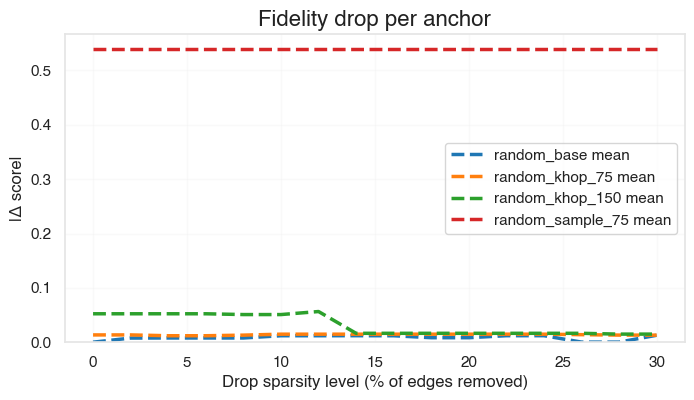

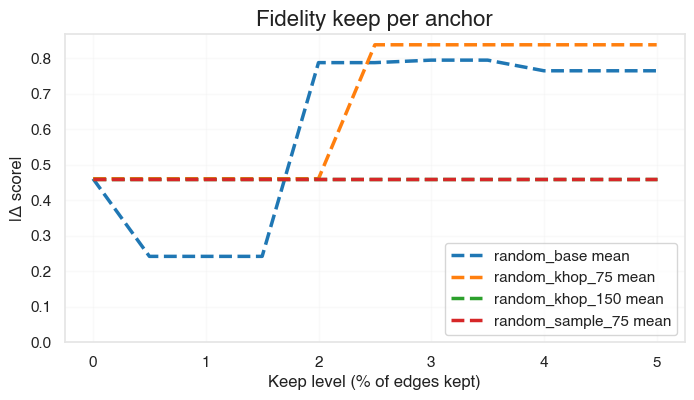

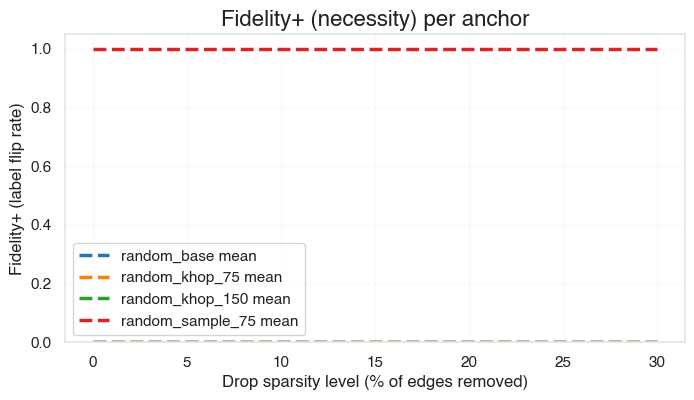

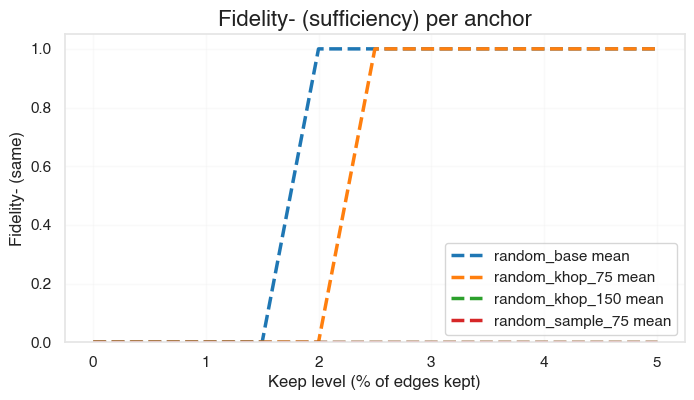

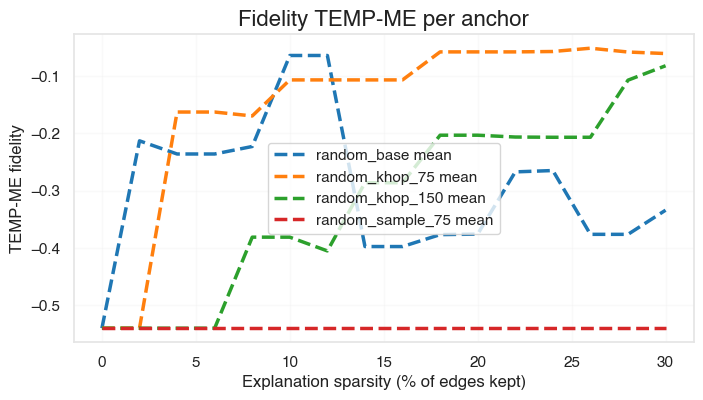

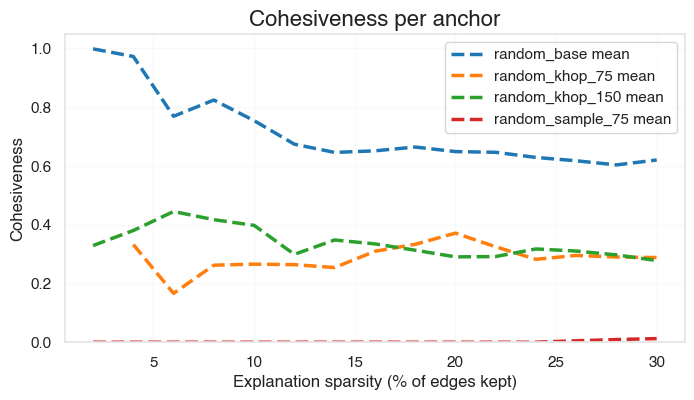

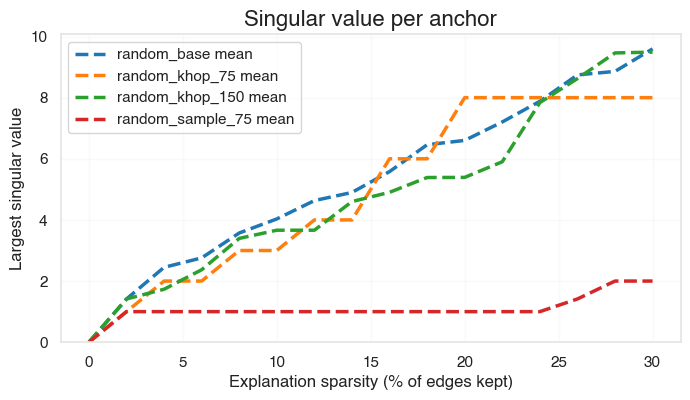


Fidelity drop (prefix=fidelity_drop.@):
  random_base: mean=0.0083, min=0.0000, max=0.0128, n=16
  random_khop_75: mean=0.0139, min=0.0119, max=0.0148, n=16
  random_khop_150: mean=0.0320, min=0.0149, max=0.0564, n=16
  random_sample_75: mean=0.5398, min=0.5398, max=0.5398, n=16

Fidelity keep (prefix=fidelity_keep.@):
  random_base: mean=0.6036, min=0.2416, max=0.7941, n=11
  random_khop_75: mean=0.6659, min=0.4602, max=0.8373, n=11
  random_khop_150: mean=0.4602, min=0.4602, max=0.4602, n=11
  random_sample_75: mean=0.4602, min=0.4602, max=0.4602, n=11

Fidelity+ (necessity) (prefix=fidelity_plus.@):
  random_base: mean=0.0000, min=0.0000, max=0.0000, n=16
  random_khop_75: mean=0.0000, min=0.0000, max=0.0000, n=16
  random_khop_150: mean=0.0000, min=0.0000, max=0.0000, n=16
  random_sample_75: mean=1.0000, min=1.0000, max=1.0000, n=16

Fidelity- (sufficiency) (prefix=fidelity_minus.@):
  random_base: mean=0.6364, min=0.0000, max=1.0000, n=11
  random_khop_75: mean=0.5455, min=0.000

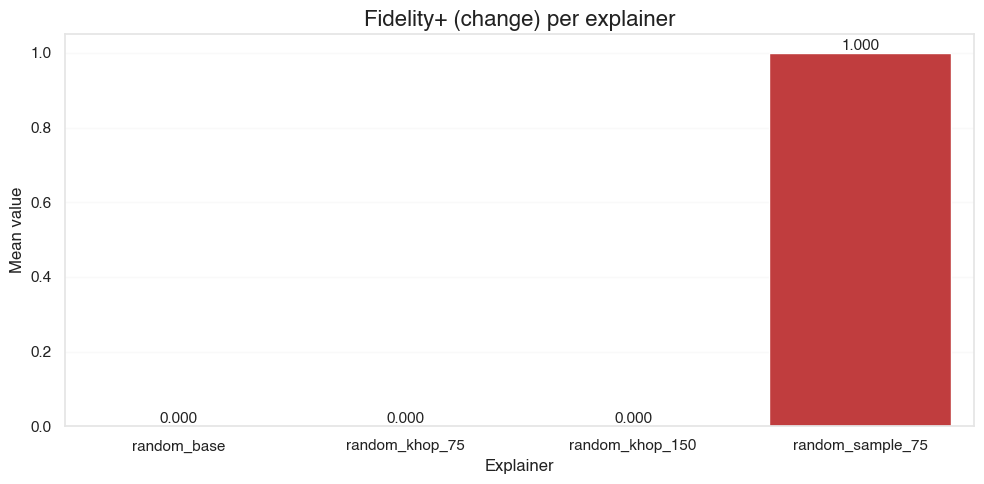

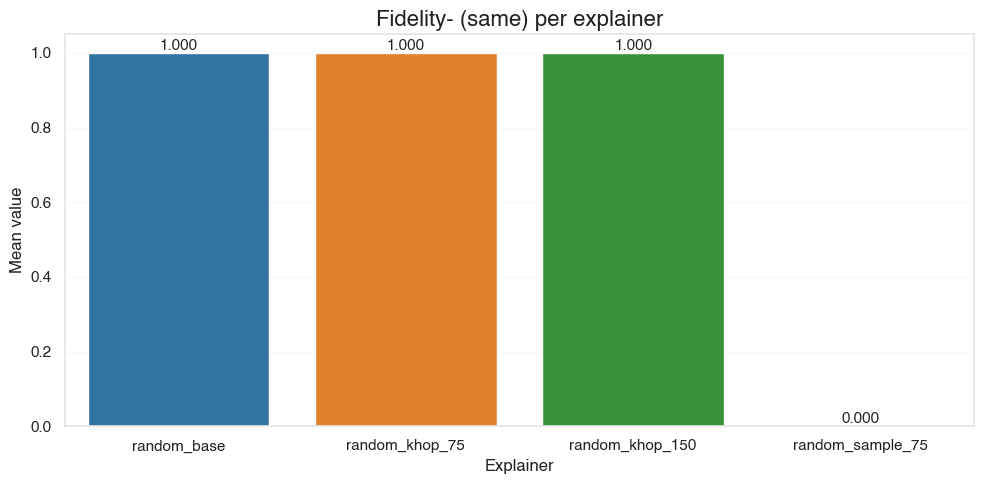

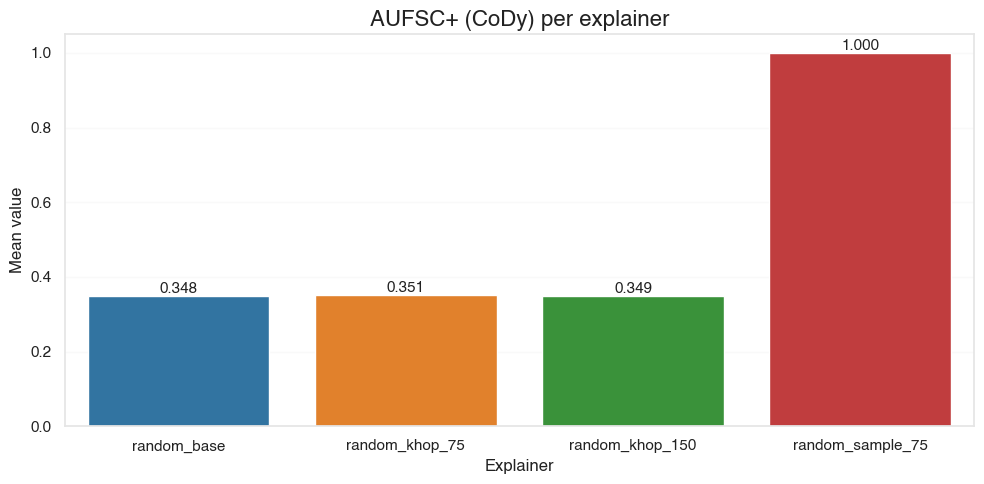

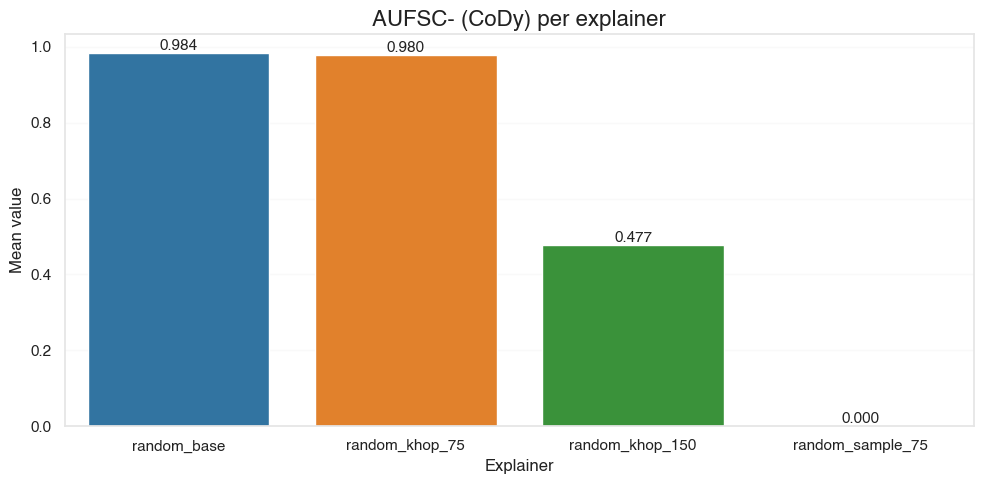

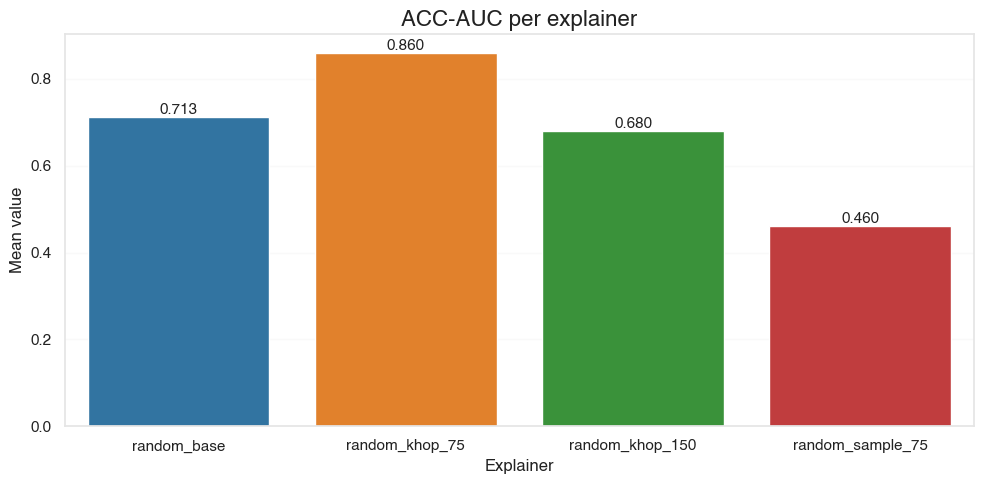

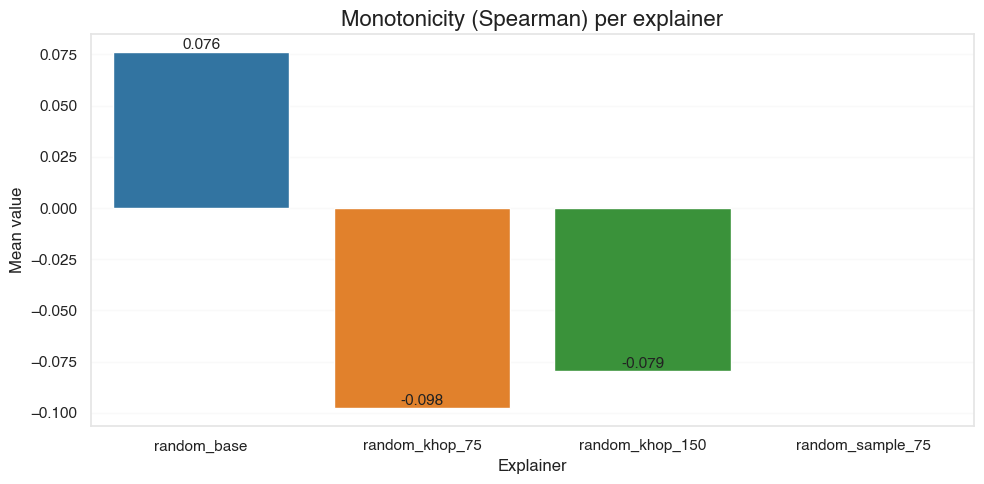

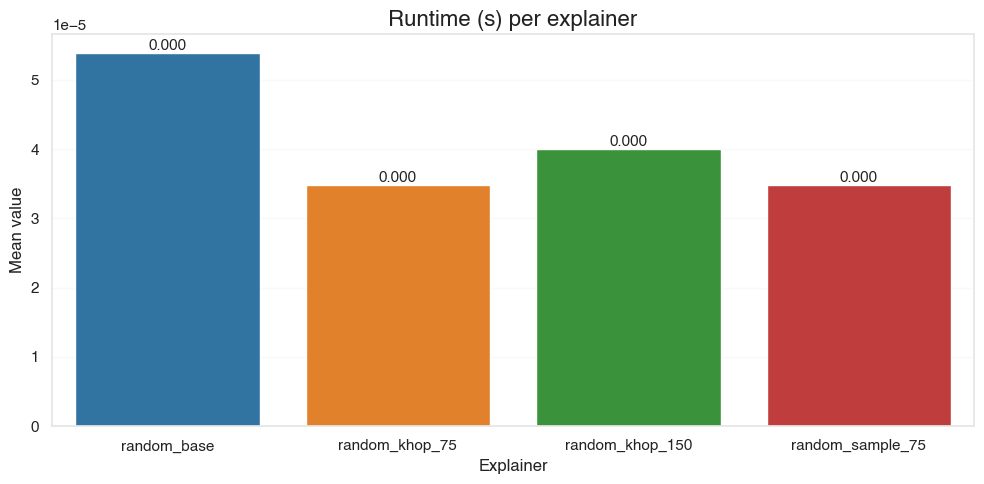

Aggregate metrics per explainer:


Fidelity+ (change)  Fidelity- (same)  AUFSC+ (CoDy)  \
explainer                                                               
random_base                      0.0               1.0       0.347826   
random_khop_75                   0.0               1.0       0.351351   
random_khop_150                  0.0               1.0       0.348993   
random_sample_75                 1.0               0.0       1.000000   

                  AUFSC- (CoDy)   ACC-AUC  Monotonicity (Spearman)  \
explainer                                                            
random_base            0.983696  0.713107                 0.076047   
random_khop_75         0.979730  0.859896                -0.097794   
random_khop_150        0.476510  0.679834                -0.079497   
random_sample_75       0.000000  0.460216                      NaN   

                  Runtime (s)  
explainer                      
random_base          0.000054  
random_khop_75       0.000035  
random_khop_150      0.000040  
random_sample_75     0.000035

In [ ]:

bases = sorted(metrics_df["explainer_base"].dropna().unique())
if VIS_BASE_EXPLAINERS:
    bases = [b for b in bases if b in VIS_BASE_EXPLAINERS]

for base in bases:
    base_df = metrics_df[metrics_df["explainer_base"] == base].copy()
    if base_df.empty:
        continue
    base_df["explainer"] = base_df["extractor_variant"]
    extractor_order = [name for name in EXTRACTOR_VARIANTS.keys() if name in set(base_df["explainer"])]
    base_df, palette = prepare_metrics_plotting(
        base_df, explainer_order=extractor_order
    )
    print(f"Explainer: {base}")
    _ = plot_selected_metrics(
        base_df,
        METRICS_TO_PLOT,
        palette=palette,
        group_col="explainer",
    )
